In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k


Quantum Teleportation
=====================

This tutorial walks you through a popular quantum information technique
known as *quantum teleportation*. While teleportation has been thought
of as the stuff of sci-fi legend, we are going to prove that it is
actually already possible today! The technique leverages many
foundational principles of quantum computing, and it has lots of useful
applications across the entire field. These principles include (but are
not limited to): the no-cloning theorem, quantum entanglement, and the
principle of deferred measurement. Let\'s dive in!


Goal: Transferring Quantum Information
--------------------------------------

Suppose there are two researchers named Alice and Bob, and Alice wants
to send her quantum state to Bob. The quantum teleportation protocol
enables Alice to do exactly this in a very elegant manner, and it can be
described in four steps:

1\. State preparation: Alice initializes her qubit to the state she
wishes to teleport.

2\. Shared entanglement: A Bell state is created and distributed to
Alice and Bob (one qubit each).

3\. Change of basis: Alice converts her two qubits from the Bell basis
to the computational basis.

4\. Measurement: Alice measures her two qubits, then tells Bob how to
convert his qubit to obtain the desired state. Note that it is only
quantum *information* being teleported, and not a physical particle.

An overview of the protocol can be seen here:


Problem: The No-Cloning Theorem
-------------------------------

You might be wondering why we need to teleport a state at all. Can\'t
Alice just make a copy of it and send the copy to Bob? It turns out that
copying arbitrary states is *prohibited*, which you can understand using
something called the **no-cloning theorem**. The proof is surprisingly
straightforward. Suppose we would like to design a circuit (unitary
transformation) $U$ that can perform the following action:

$$\begin{aligned}
\begin{align*}
U(\vert \psi\rangle \otimes \vert s\rangle ) &= \vert \psi\rangle \otimes \vert \psi\rangle, \\
U(\vert \varphi\rangle \otimes \vert s\rangle ) &= \vert \varphi \rangle \otimes \vert \varphi \rangle,
\end{align*}
\end{aligned}$$

where $\vert \psi\rangle$ and $\vert \varphi\rangle$ are arbitrary,
normalized single-qubit states, and $\vert s \rangle$ is some arbitrary,
normalized starting state. We will now prove that no such $U$ exists!

First, let\'s take the inner product of the left-hand sides of the two
equations:

$$(\langle \psi \vert \otimes \langle s \vert) U^\dagger U(\vert \varphi\rangle \otimes \vert s\rangle ) = \langle \psi \vert \varphi\rangle \  \langle s \vert s\rangle$$

Since $\langle s \vert s\rangle$ equals 1, this evaluates to
$\langle \psi \vert \varphi \rangle$. Next, we compare the inner product
of the right-hand sides of the two equations:
$(\langle \psi \vert \varphi \rangle)^2$. These inner products must be
equal, and they are only equal if they are a value that squares to
itself. The only valid values for the inner product then are 1 and 0.
But if the inner product is 1, the states are the same; on the other
hand, if the inner product is 0, the states are orthogonal. Therefore,
we can\'t clone arbitrary states!

Solution: Quantum Teleportation
-------------------------------

We will now walk through how to share quantum information without
cloning it, one step at a time.


1. State preparation
====================


Teleportation involves three qubits. Two of them are held by Alice, and
the third by Bob. We\'ll denote their states using subscripts:

1.  $\vert\cdot\rangle_S$, Alice\'s first qubit that she will prepare in
    some arbitrary state
2.  $\vert\cdot\rangle_A$, Alice\'s auxiliary (or \"ancilla\") qubit
    that she will entangle with Bob\'s qubit for communication purposes
3.  $\vert \cdot\rangle_B$, Bob\'s qubit that will receive the
    teleported state

Together, their starting state is:

$$\vert 0\rangle_S \vert 0\rangle_A \vert 0\rangle_B.$$

The first thing Alice does is prepare her first qubit in whichever state
$\vert
\psi\rangle$ that she\'d like to send to Bob so that their combined
state becomes:

$$\vert \psi\rangle_S \vert 0\rangle_A \vert 0\rangle_B.$$

We can use the following [quantum
function](https://docs.pennylane.ai/en/stable/introduction/circuits.html#quantum-functions)
to do the state preparation step:


In [10]:
import pennylane as qml
import numpy as np
qcstyle="black_white"

def state_preparation(state):
    qml.StatePrep(state, wires=["S"])

2. Shared entanglement
======================


The reason why teleportation works is the use of an *entangled state* as
a shared resource between Alice and Bob. You can imagine some process
that generates a pair of entangled qubits, and sends one qubit to each
party. For simplicity (and simulation!), we will represent the
entanglement process as part of our circuit.

Entangling the qubits $A$ and $B$ leads to the combined state:

$$\frac{1}{\sqrt{2}}\left( \vert \psi\rangle_S \vert 0\rangle_A \vert 0\rangle_B + \vert \psi\rangle_S \vert 1\rangle_A \vert 1\rangle_B \right)\tag{1}$$

The $AB$ subsystem is now in what is known as a *Bell state*. There are
four maximally entangled two-qubit Bell states, and they form the Bell
basis:

$$\begin{aligned}
\begin{align*}
\vert \psi_+\rangle &= \frac{1}{\sqrt{2}} \left( \vert 00\rangle + \vert 11\rangle \right), \\
\vert \psi_-\rangle &= \frac{1}{\sqrt{2}} \left( \vert 00\rangle - \vert 11\rangle \right), \\
\vert \phi_+\rangle &= \frac{1}{\sqrt{2}} \left( \vert 01\rangle + \vert 10\rangle \right), \\
\vert \phi_-\rangle &= \frac{1}{\sqrt{2}} \left( \vert 01\rangle - \vert 10\rangle \right).
\end{align*}
\end{aligned}$$

In our experiment, because $AB$ started in the $\vert 00\rangle$ state,
we create the $\vert \psi_+\rangle$ Bell state as is shown in equation
(1).


In [3]:
def entangle_qubits():
    qml.Hadamard(wires="A")
    qml.CNOT(wires=["A", "B"])

From now on, the qubit subscripts will be removed from states for
brevity.

3. Change of basis
==================

This is where things get tricky, but also very interesting. The third
step of the protocol is to apply a CNOT and a Hadamard to the first two
qubits. This is done prior to the measurements, and labelled \"change of
basis\". But what basis is this? Notice how these two gates are the
*opposite* of what we do to create a Bell state. If we run them in the
opposite direction, we transform the basis back to the computational
one, and simulate a measurement in the Bell basis.

After the basis transform, if we observe the first two qubits to be in
the state $\vert 00\rangle$, this would correspond to the outcome
$\vert \psi_+\rangle$ in the Bell basis, $\vert 11\rangle$ would
correspond to $\vert \phi_-\rangle$, etc. Let\'s perform this change of
basis, one step at a time.

Suppose we write our initial state $\vert \psi\rangle$ as
$\alpha\vert 0\rangle + \beta\vert 1\rangle$, with $\alpha$ and $\beta$
being complex coefficients. Expanding out the terms from (1), we obtain:

$$\frac{1}{\sqrt{2}} ( \alpha\vert 000\rangle +
\beta\vert 100\rangle + \alpha \vert 011\rangle +
\beta\vert 111\rangle )$$

Now let\'s apply a CNOT between Alice\'s two qubits:

$$\frac{1}{\sqrt{2}} ( \alpha\vert 000\rangle +
\beta\vert 110\rangle + \alpha \vert 011\rangle +
\beta\vert 101\rangle )$$

And then a Hadamard on her first qubit:

$$\frac{1}{2} ( \alpha \vert 000\rangle + \alpha\vert 100\rangle + \beta\vert 010\rangle - \beta\vert 110\rangle + \alpha \vert 011\rangle + \alpha \vert 111 \rangle + \beta\vert 001\rangle - \beta\vert 101 \rangle ).$$

Now we need to do some rearranging. We group the terms based on the
first two qubits:

$$\frac{1}{2} \vert 00\rangle(\alpha\vert 0\rangle + \beta\vert 1\rangle) + \frac{1}{2}\vert 01\rangle (\beta\vert 0\rangle + \alpha\vert 1\rangle) + \frac{1}{2}\vert 10\rangle (\alpha\vert 0\rangle - \beta\vert 1\rangle) + \frac{1}{2}\vert 11\rangle (-\beta\vert 0\rangle + \alpha\vert 1\rangle).\tag{2}$$


In [4]:
def basis_rotation():
    qml.CNOT(wires=["S", "A"])
    qml.Hadamard(wires="S")

4. Measurement
==============


The last step of the protocol involves Alice performing a measurement on
her qubits, and telling Bob to perform some operations depending on what
she measured. But why exactly do we need to do this? In the previous
step, we already performed a basis rotation back to the computational
basis, so shouldn\'t we be good to go? Not quite, but almost!

Let\'s take another look at equation (2). If Alice measures her two
qubits in the computational basis, she is equally likely to obtain any
of the four possible outcomes. If she observes the first two qubits in
the state $\vert 00 \rangle$, she would immediately know that Bob\'s
qubit was in the state $\alpha \vert 0 \rangle + \beta \vert 1 \rangle$,
which is precisely the state we are trying to teleport!

If instead she observed the qubits in state $\vert 01\rangle$, she\'d
still know what state Bob has, but it\'s a little off from the original
state. In particular, we have:

$$\beta \vert 0 \rangle + \alpha \vert 1 \rangle = X \vert \psi \rangle.$$

After obtaining these results, Alice could tell Bob to simply apply an X
gate to his qubit to recover the original state. Similarly, if she
obtained $\vert 10\rangle$, she would tell him to apply a Z gate.

In the [\"traditional\" version of quantum
teleportation](https://quantum.country/teleportation), this is, in fact,
exactly what happens. Alice would call up Bob on the phone, tell him
which state she observed, and then he would be able to apply an
appropriate correction. In this situation, measurements are happening
partway through the protocol, and the results would be used to control
the application of future quantum gates. This is known as mid-circuit
measurement, and such mid-circuit measurements are expressed in
PennyLane using `qml.measure <pennylane.measure>`{.interpreted-text
role="func"}. Mid-circuit measurement results can be used to control
operations, and this is expressed in PennyLane using
`qml.cond <pennylane.cond>`{.interpreted-text role="func"}.


In [5]:
def measure_and_update():
    m0 = qml.measure("S")
    m1 = qml.measure("A")
    qml.cond(m1, qml.PauliX)("B")
    qml.cond(m0, qml.PauliZ)("B")

We\'ve now defined all the building blocks for the quantum teleportation
protocol. Let\'s put it all together!


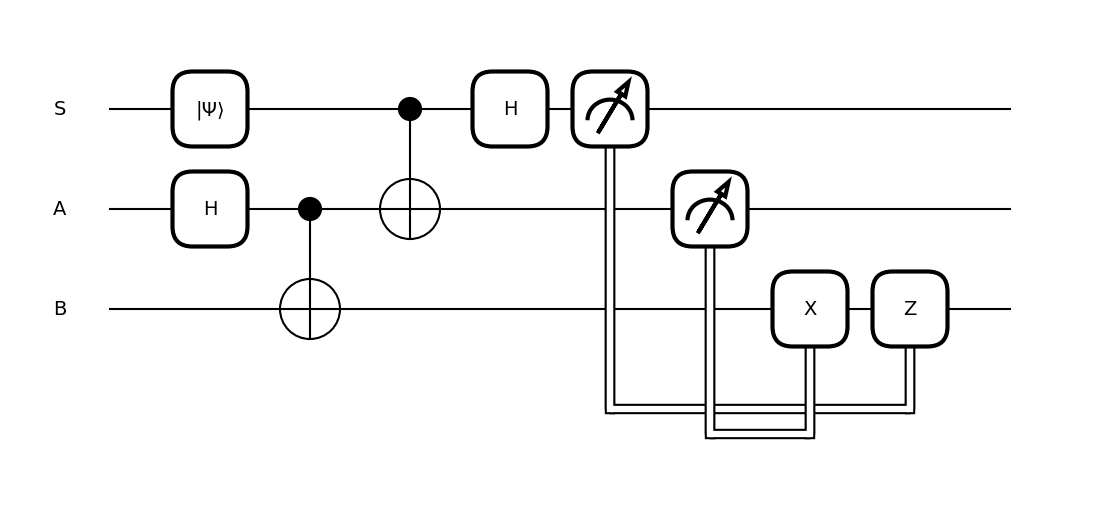

In [11]:
def teleport(state):
    state_preparation(state)
    entangle_qubits()
    basis_rotation()
    measure_and_update()


state = np.array([1 / np.sqrt(2) + 0.3j, 0.4 - 0.5j])
_ = qml.draw_mpl(teleport, style=qcstyle)(state)

There is a neat concept known as the [principle of deferred
measurement](https://en.wikipedia.org/wiki/Deferred_Measurement_Principle),
and it basically states that we can push all our measurements to the
*end* of our circuit. This can be useful for a variety of reasons, such
as when working in a system that does not support mid-circuit
measurements. In PennyLane, when you bind a circuit to a device that
does not support them, it will automatically apply the principle of
deferred measurement and update your circuit to use controlled
operations instead. Note that you need to specify
`expansion_strategy="device"` when calling `draw_mpl` so it runs the
device pre-processing before drawing the circuit.


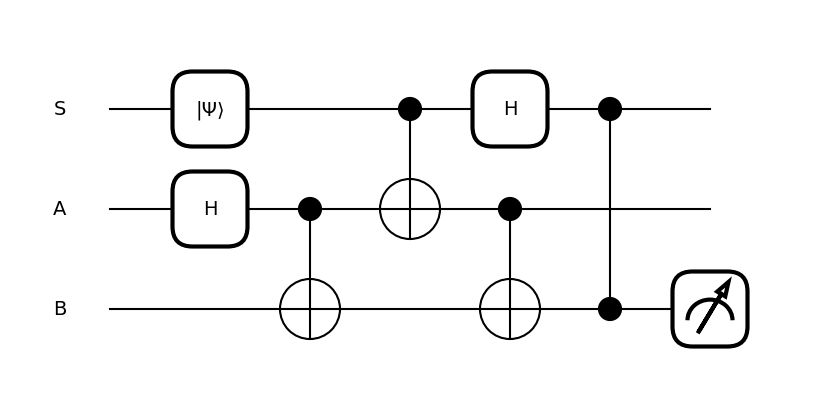

In [12]:
dev = qml.device("default.qubit", wires=["S", "A", "B"])


@qml.qnode(dev)
def teleport(state):
    state_preparation(state)
    entangle_qubits()
    basis_rotation()
    measure_and_update()
    return qml.density_matrix(wires=["B"])


_ = qml.draw_mpl(teleport, style=qcstyle, expansion_strategy="device")(state)

Poof! Our classical signals have been turned into CNOT and CZ gates.
This is exactly what the principle of deferred measurement gives us ---
we can apply a CNOT instead of Alice calling Bob and telling him to
apply an X gate, and likewise for the CZ gate. This is incredibly
useful, as it allows us to perform our correction *before* any
measurements are made. Let\'s evaluate the action of the CNOT and CZ on
Bob\'s qubit, and ensure that Alice\'s state has been successfully
teleported. Applying the CNOT yields:

$$\frac{1}{2} \vert 00\rangle(\alpha\vert 0\rangle + \beta\vert 1\rangle) + \frac{1}{2}\vert 01\rangle (\alpha\vert 0\rangle + \beta\vert 1\rangle) + \frac{1}{2}\vert 10\rangle (\alpha\vert 0\rangle - \beta\vert 1\rangle) + \frac{1}{2}\vert 11\rangle (\alpha\vert 0\rangle - \beta\vert 1\rangle)$$

Then, applying the CZ yields:

$$\frac{1}{2} \vert 00\rangle(\alpha\vert 0\rangle + \beta\vert 1\rangle) + \frac{1}{2}\vert 01\rangle (\alpha\vert 0\rangle + \beta\vert 1\rangle) + \frac{1}{2}\vert 10\rangle (\alpha\vert 0\rangle + \beta\vert 1\rangle) + \frac{1}{2}\vert 11\rangle (\alpha\vert 0\rangle + \beta\vert 1\rangle)\tag{3}$$

When Alice measures her two qubits at the end, no matter which outcome
she gets, Bob\'s qubit will be in the state
$\alpha\vert 0\rangle + \beta \vert
1\rangle$. This means that our protocol has changed the state of Bob\'s
qubit into the one Alice wished to send him, which is truly incredible!

We can use
`qml.density_matrix <pennylane.density_matrix>`{.interpreted-text
role="func"} to trace out and return Bob\'s subsystem as a density
matrix, which is a more general description of the state of his qubit.
We will use this to verify that Alice\'s state was successfully
teleported to Bob\'s qubit. Re-arranging equation (3), we can see that
the final state of the system is:

$$\frac{1}{2} (\vert 00\rangle + \vert 01\rangle + \vert 10\rangle + \vert 11\rangle) \vert \psi\rangle\tag{4}$$

Now, we can confirm that our implementation of the quantum teleportation
protocol is working as expected by comparing Bob\'s final density matrix
to Alice\'s original density matrix:


In [8]:
def teleport_state(state):
    teleported_density_matrix = teleport(state)
    original_density_matrix = qml.math.dm_from_state_vector(state)

    if not np.allclose(teleported_density_matrix, original_density_matrix):
        raise ValueError(
            f"Alice's state ({state}) not teleported properly. "
            f"Final density matrix of Bob's subsystem: {teleported_density_matrix}"
        )
    print("State successfully teleported!")


teleport_state(state)

State successfully teleported!


Conclusion
==========

Let\'s recap the concepts we\'ve learned throughout this tutorial.
First, we established that quantum states cannot be arbitrarily copied
due to the *no-cloning theorem*. Then, we learned about *quantum
entanglement*. Once Alice and Bob shared an entangled pair of qubits,
Alice performed a *change of basis* from the Bell basis to the
computational basis. Finally, using the *principle of deferred
measurement* when needed, Alice measured her two qubits and informed Bob
on how to rotate his qubit into the desired state.

Just like that, Alice and Bob performed quantum teleportation, and with
a fairly small circuit! Some of you may now be thinking that
teleportation is impossible, and you would be in good company if so.
Einstein himself referred to the non-local nature of entanglement as
\"spooky action at a distance\", but we can all rest easy: due to the
need for classical communication from Alice to Bob, quantum states (in
other words, information) still cannot be teleported faster than the
speed of light. Don\'t let that take away from the importance of quantum
teleportation! This protocol is a critical tool in quantum information
processing, and now it is a tool that you wield.

References
==========


About the author
================
